In [1]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from sklearn.decomposition import NMF, LatentDirichletAllocation

Load the entire features dataframe

In [2]:
import os
events = [x for x in os.listdir('../../../Project Data/Tweets/') if "DS_Store" not in x]

all_tweets = list()
for event in events:
    all_tweets.append(pickle.load(open('../../../Project Data/Tweets/{}/Geocoded/summary.pickle'.format(event), 'rb')))

# Setting 
for idx, country in enumerate(["BE", "FR", "TR", "LB", "NG", "NG", "US", "PK"]):
    if country== "BE":
        all_tweets[idx].loc["FR",:] = np.nan
    if country== "FR":
        all_tweets[idx].loc["BE",:] = np.nan
    if country == "US":
        all_tweets[idx].loc["BE",:] = np.nan
        all_tweets[idx].loc["FR",:] = np.nan
    all_tweets[idx].loc[country,:] = np.nan

all_tweets = pd.concat(all_tweets, axis=1).mean(axis=1, skipna = True)
all_tweets.head()

all_tweets.to_pickle("all_tweets.pickle")

In [3]:
data = pickle.load(open('../DataEnriching/data.pickle','rb'))
data = data.reset_index()
data = data.set_index("ISO2")

# Keep only relevant fields 
data = data[['ISO2','POP', 'area', 'gdp', 'gdp_capita', 'pop_pov', 'region']]

lang_feature_df = pd.read_pickle('../LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence_v2.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance.pickle')
religion_and_more_df = pd.read_pickle('../DataEnriching/Pickles for Milestone 3/6_feature_df.pickle')

# Load the number of internet users
internet_users = pickle.load(open('internet_users.pickle','rb'))
internet_users.set_index("ISO2", inplace = True)
internet_users.replace("unknown", np.nan, inplace = True)
internet_users["Internet users"] = internet_users["Internet users"].astype(np.float)
med = np.median([x for x in internet_users["Internet users"].tolist() if not np.isnan(x)])
internet_users = internet_users["Internet users"].apply(lambda x: x if not(np.isnan(x)) else med)

# drop the name column : 
religion_and_more_df.drop(['name','POP'],axis=1,inplace=True)

#carefull the number of coutries is not the same in every pickle.
features_df = pd.concat([lang_feature_df,
           fligh_routes_df,
           hop_distance_df,
           neighbor_influence_df,
          dist_feature_df, data],axis=1)
#features_df.sort_index(axis=1,inplace=True)

features_df.loc[:,("Internet users")] = internet_users
features_df.loc[:,("Normalized internet users")] = med

# Go through all the countries and compute the normalized 
# number of internet users based on population 
# if the number of internet users is not given replace
# with the minimum between the number of internet users and population

for country in tqdm(features_df.index):
    users = features_df.loc[country,:]["Internet users"][0]
    pop = features_df.loc[country, :]["POP"][0]
    val = min(users, pop)/pop
    med_val =  min(med, pop)/pop
    #print(features_df.loc[country,"Normalized internet users"])
    
    if  (users!= -1) and (not(np.isnan(users))) and (not(np.isnan(pop))):
        if not np.isnan(val):
            features_df.loc[country,("Normalized internet users")] = val 
        else :
            features_df.loc[country,("Normalized internet users")]  = med_val
    else :
        features_df.loc[country,("Normalized internet users")]  = med_val

features_df.head()

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/ipykernel/__main__.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
100%|██████████| 248/248 [00:01<00:00, 213.97it/s]


language_dist                                                              \
              AW        AF        AO        AI        AX        AL        AD   
AD     -0.577939 -0.398997 -0.910258 -0.245619 -0.347871 -0.654628 -1.217014   
AE      1.492665 -0.705754  1.492665  1.492665  1.492665  1.492665  1.492665   
AF     -0.322308 -1.217014 -0.194493 -0.450123 -0.552376 -0.859132 -0.398997   
AG     -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754 -0.245619   
AI     -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754 -0.245619   

                                            ...            real_distance  \
          AE        AR        AM            ...                       ZM   
AD  1.492665 -1.012510 -0.526813            ...                64.175541   
AE -1.217014  1.492665  1.492665            ...                45.793013   
AF -0.705754 -0.296745 -0.731317            ...                59.405387   
AG  1.492665 -0.143367 -0.577939            ...                97.233958   
AI  1.492665 -0.143367 -0.577939            ...                98.922142   

                       POP      area           gdp gdp_capita pop_pov  \
            ZW                                                          
AD   68.691339     85660.0     468.0  4.800000e+09    37200.0   0.143   
AE   50.119856   5927482.0   83600.0  3.750000e+11    67700.0   0.195   
AF   63.513778  33332025.0  652230.0  1.840000e+10     2000.0   0.358   
AG   98.994659     93581.0     442.0  1.303000e+09    24100.0     NaN   
AI  100.712910     16752.0      91.0  1.754000e+08    12200.0   0.230   

                               region Internet users Normalized internet users  
                                                                                
AD                             Europe           83.0                  0.000969  
AE                        Middle East      5274000.0                  0.889754  
AF                               Asia      2690000.0                  0.080703  
AG  Central America and the Caribbean           60.0                  0.000641  
AI  Central America and the Caribbean           12.0                  0.000716  

[5 rows x 1244 columns]

In [4]:
features_df.to_pickle("correlation_features.pkl")

Functions used to process a given event

In [5]:
def load_tweets(event, country_code):
    plt.figure(figsize = (15,10))
    # Loading the Number of tweets of the event in turkey per country
    summary_tweets = pickle.load(open('../../../Project Data/Tweets/{}/Geocoded/summary.pickle'.format(event), 'rb'))
    #plot = sns.barplot(summary_tweets.index,summary_tweets.text)
    return summary_tweets


def event_specific_features(country_code, summary_tweets):
    # Create the dataframe for the given country
    country_features_df = pd.concat([lang_feature_df.loc[:,("language_dist",country_code)],
                           fligh_routes_df.loc[:,("flight_routes",country_code)],
                           hop_distance_df.loc[:,("hop_distance",country_code)],
                           neighbor_influence_df.loc[:,("neighbor_influence",country_code)],
                           dist_feature_df.loc[:,("real_distance",country_code)], 
                           summary_tweets.loc[:,"text"],
                           data.loc[:,["area", 'gdp', 'gdp_capita', "POP", "2016_gdp_total", "region"]],
                           features_df.loc[:,("Normalized internet users")],
                           features_df.loc[:,("Internet users")]],axis=1)
    #features_df.sort_index(axis=1,inplace=True)

    # Rename the columns
    country_features_df.columns = ['language_dist', 'flight_routes', 'hop_distance', 'neighbor_influence',\
                                   'real_distance', 'text', 'POP', 'area', 'gdp', 'gdp_capita',\
                                    'region', 'Normalized internet users', 'Internet users']
    
    # Change the type of the given columns from object to float
    country_features_df.flight_routes = country_features_df.flight_routes.astype(np.float)
    country_features_df.neighbor_influence = country_features_df.neighbor_influence.astype(np.float)
    
    #country_features_df["text"] = np.log(country_features_df["text"]+1)
    
    country_features_df["Normalized Tweets"] = (country_features_df["text"]-all_tweets) / (all_tweets+1)


    # Remove the information pretaining to the concerned country
    country_features_df.drop([country_code], inplace = True)
    #country_features_df.drop(["BE", "FR"], inplace = True)
    return country_features_df

# Plot correlations between the different metrics and the number of tweets
# Compute the regression with R squared metric

def plot_correlations_with_regression(country_features_df):
    fig = plt.figure(figsize = (15,20))

    y_all = country_features_df.loc[:,'Normalized Tweets'].tolist()

    # Compute and plot the correlations for the first columns
    for idx, column in enumerate(country_features_df.columns):
        if idx<9:
            # Create the plot
            ax = plt.subplot(len(country_features_df.columns)//3+1, 3, idx+1)
            
            # Get the x and y values if x is not infinite or nan
            
            x_all = country_features_df.loc[:,column].tolist()
            x = list()
            y = list()

            for i in range(len(x_all)):
                if (not np.isnan(x_all[i]) and not np.isinf(x_all[i])):
                    x.append(x_all[i])
                    y.append(y_all[i])            

            # Plot the original data
            ax.plot(x, y, 'o', label='original data')
            
            # Compute the linear regression 
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
            # Plot the regression 
            ax.plot(np.array(x), intercept + slope*np.array(x), '--r', label='fitted line')
            ax.legend()
            ax.set_xlabel(column)
            ax.set_ylabel("Normalized number of tweets")
            plt.title("{} : r^2 {:.3f}".format(column, r_value**2) )
    fig.tight_layout()


def analyse_event(event_name, country_code, for_region = False):
    
    summary_tweets = load_tweets(event_name, country_code)
    
    # Compute the features for a specific event
    country_features_df = event_specific_features(country_code,summary_tweets)
    
    # Keep countries for which we have the real distance metric (i.e. for which we have all information)
    country_features_df = country_features_df.loc[~ country_features_df["real_distance"].isnull(),:]
    
    # If we only want to analyze for the corresponding region
    if for_region:
        # Extract the region
        region  = data.loc[country_code, "region"][0]
        country_features_df = country_features_df.loc[country_features_df["region"] == region,:]
    
    # Remove small countries from the model
    country_features_df = country_features_df.loc[country_features_df["POP"]>100000,:]
    country_features_df = country_features_df.loc[country_features_df["area"]>1000,:]
        
    # Compute and plot the correlations
    sns.heatmap(abs(country_features_df.corr("spearman")[["text", "Normalized Tweets"]]),annot=True)
    plot_correlations_with_regression(country_features_df)

Load the tweets for an event

In [6]:
# FR : 557 km vs 5.23
# ES : 1354 km vs 13,5
# AU  : 15532 vs. 151

In [7]:
summary_tweets = load_tweets("Bruxelles", "BE")
country_features_df = event_specific_features("BE",summary_tweets)
region  = data.loc["BE", "region"][0]
country_features_df= country_features_df.loc[country_features_df["region"] == region,:]

country_features_df.loc[country_features_df["Normalized Tweets"]>5,:]

,language_dist,flight_routes,hop_distance,neighbor_influence,real_distance,text,POP,area,gdp,gdp_capita,region,Normalized internet users,Internet users,Normalized Tweets
FR,-1.217014,2.508711,1.0,2.463306,5.230785,18889.0,66836154.0,551695.0,2.488000e+12,42400.0,Europe,0.843361,56367000.0,8.057346


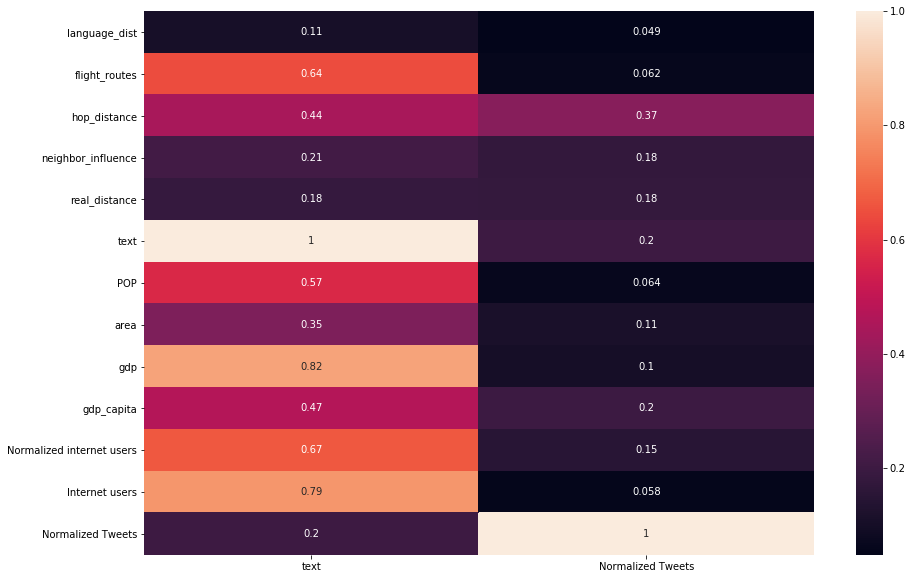

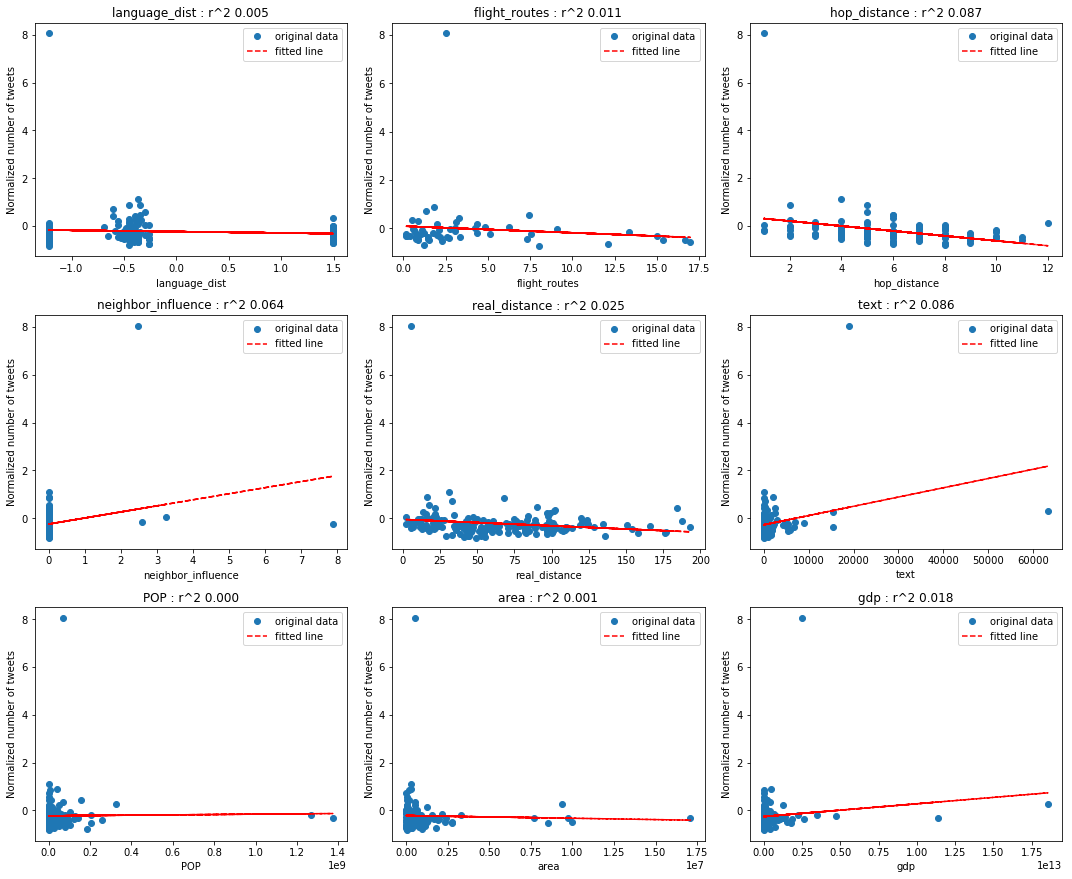

In [8]:
analyse_event("Bruxelles", "BE")

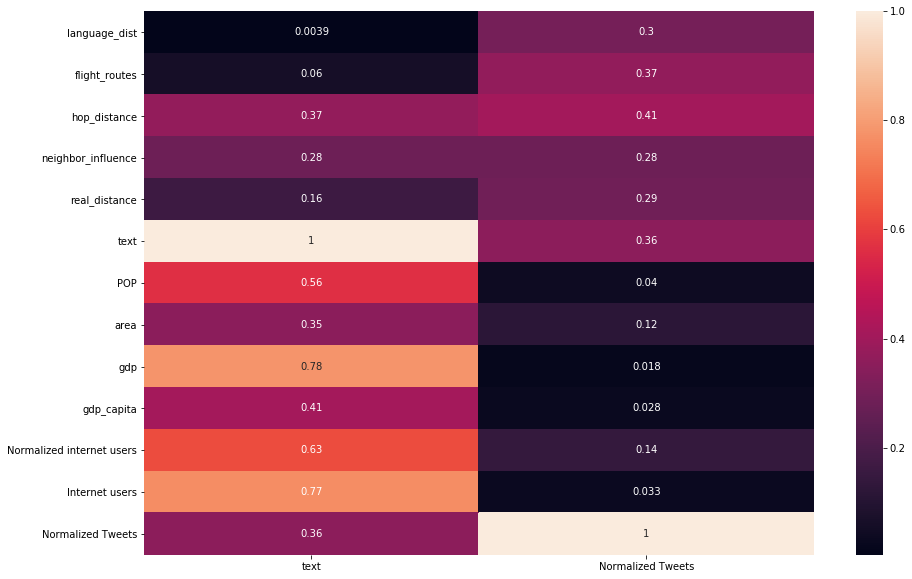

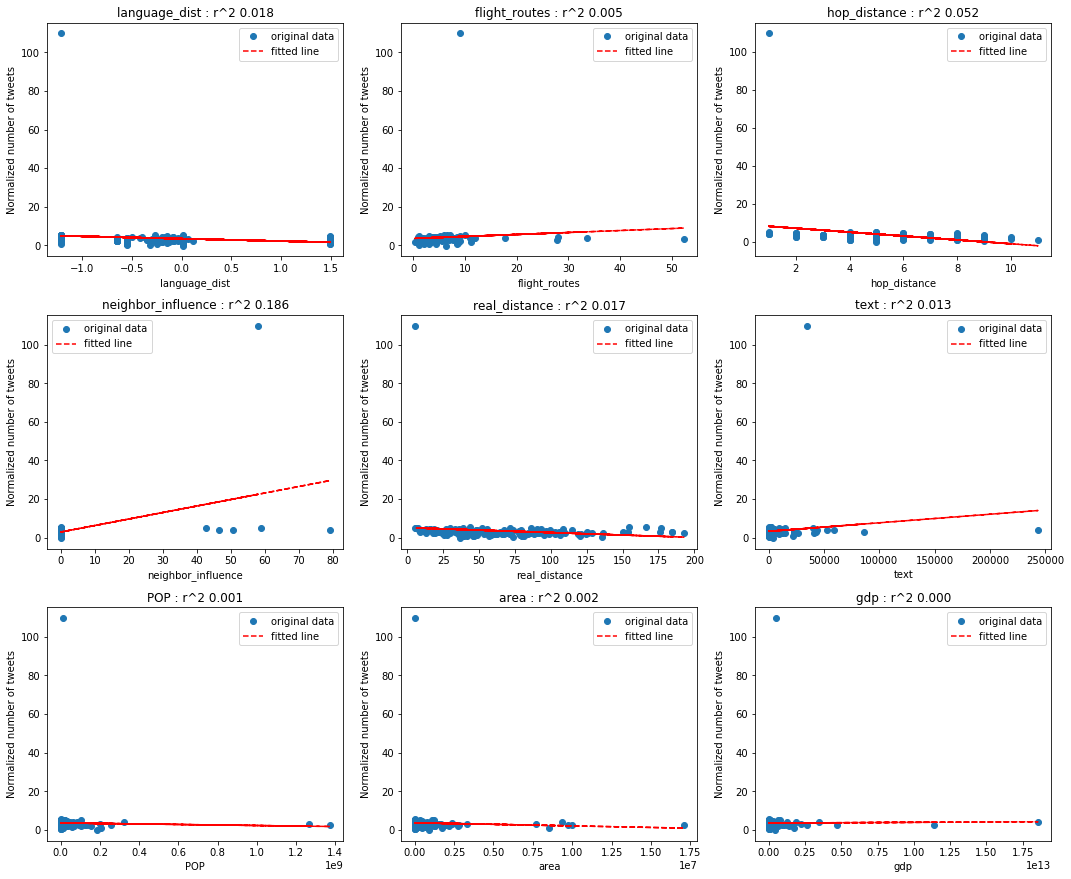

In [9]:
analyse_event("Charlie-Hebdo", "FR")

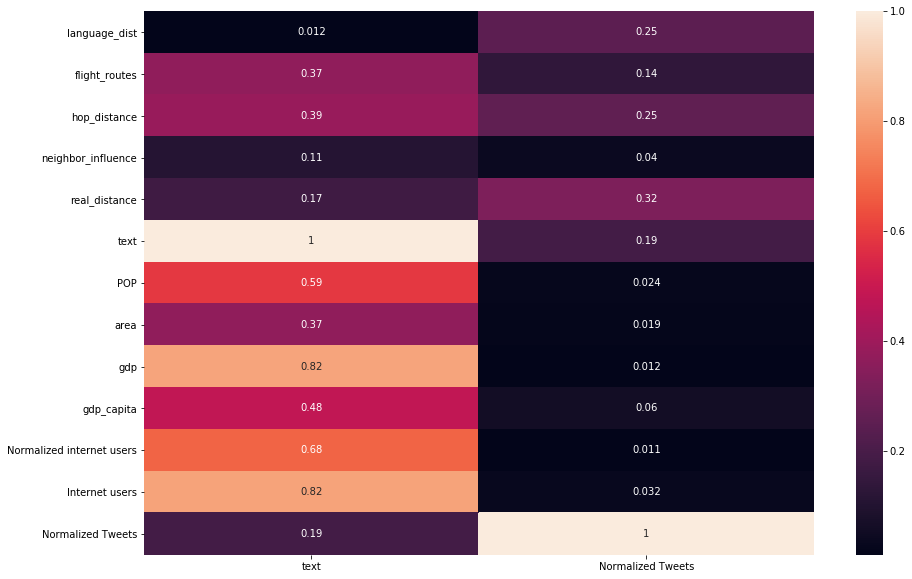

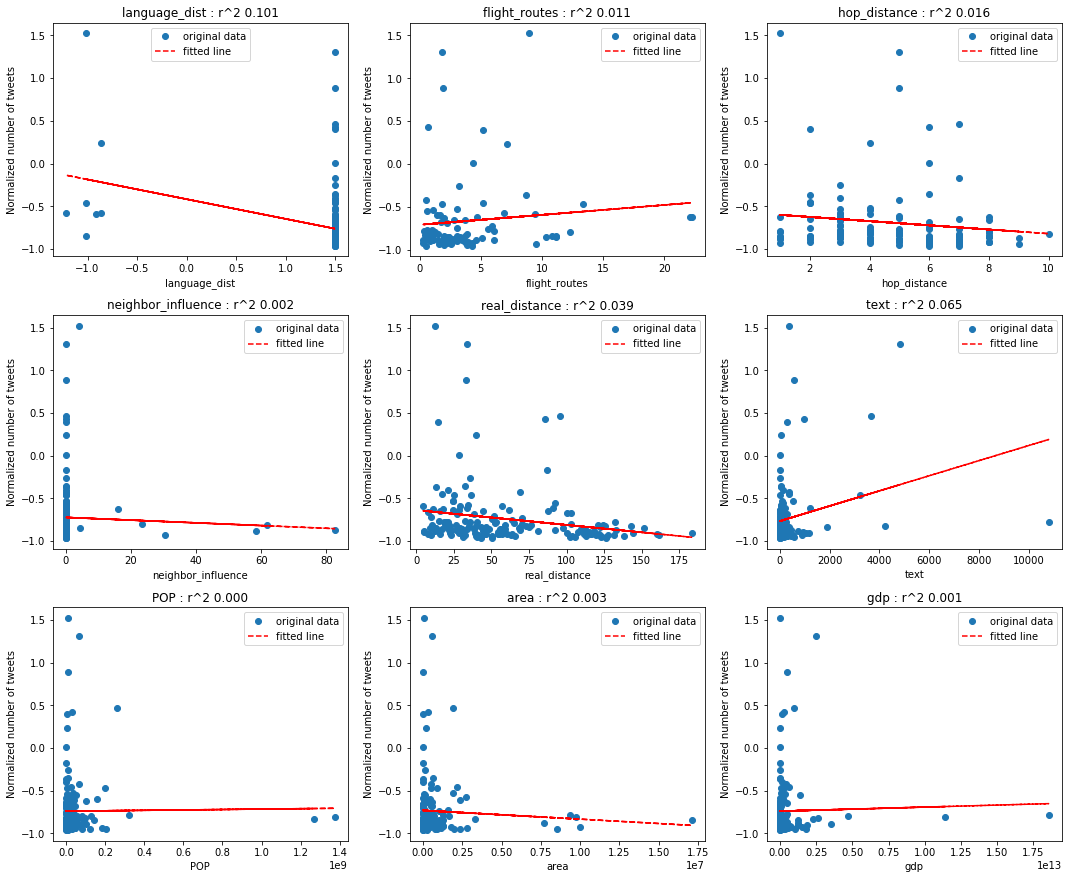

In [10]:
analyse_event("Istanbul", "TR")

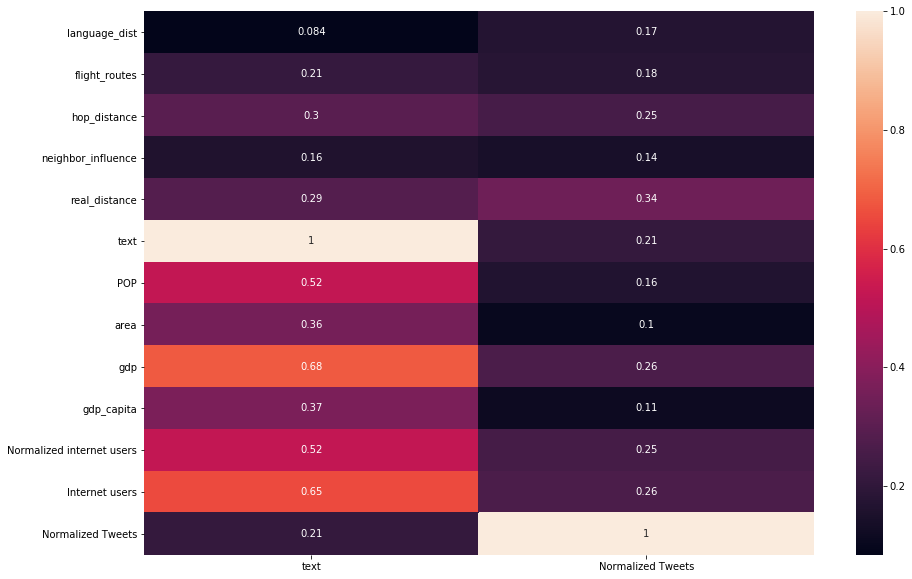

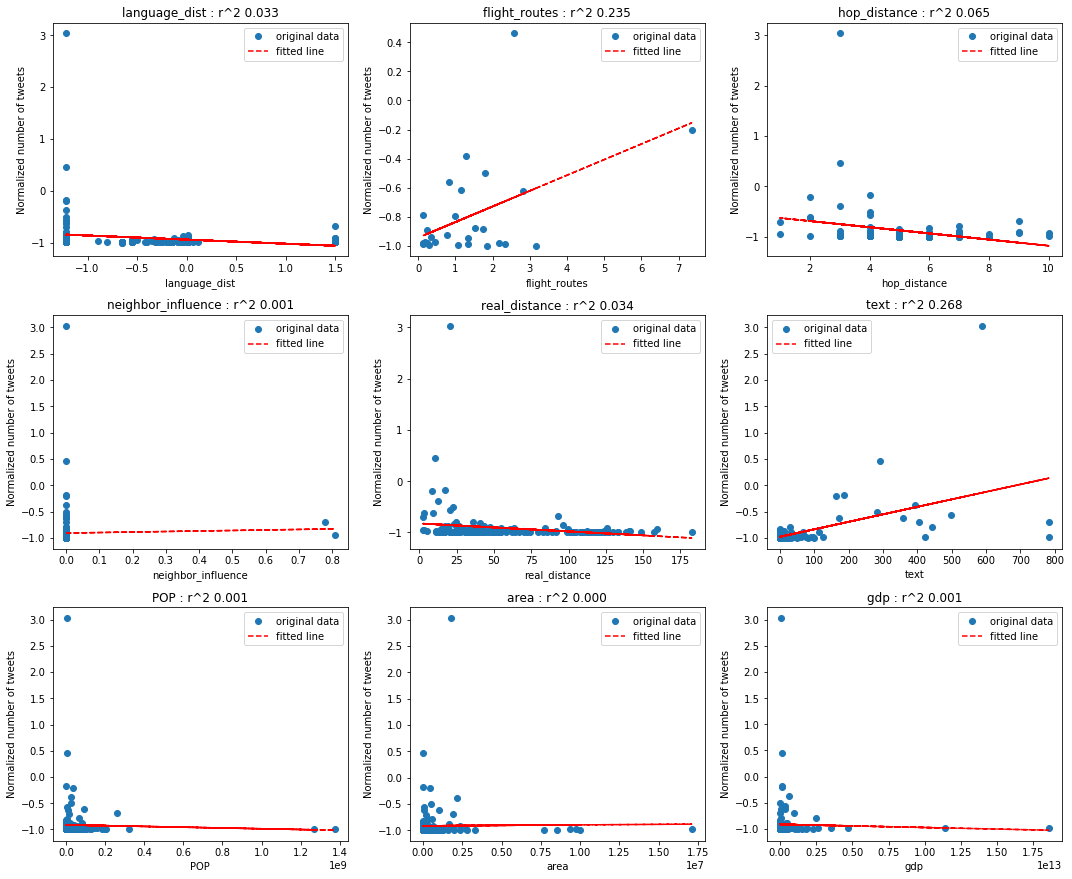

In [11]:
analyse_event("Lebanon", "LB")

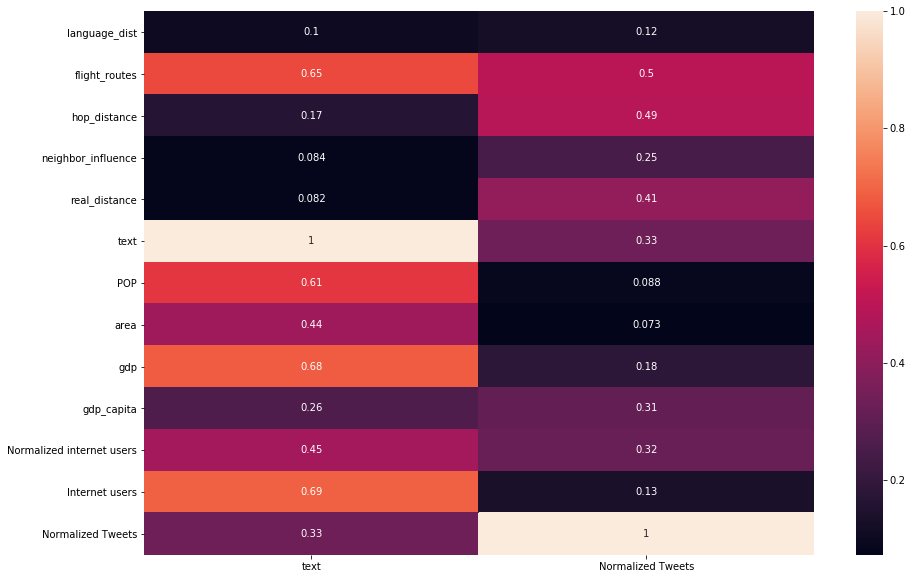

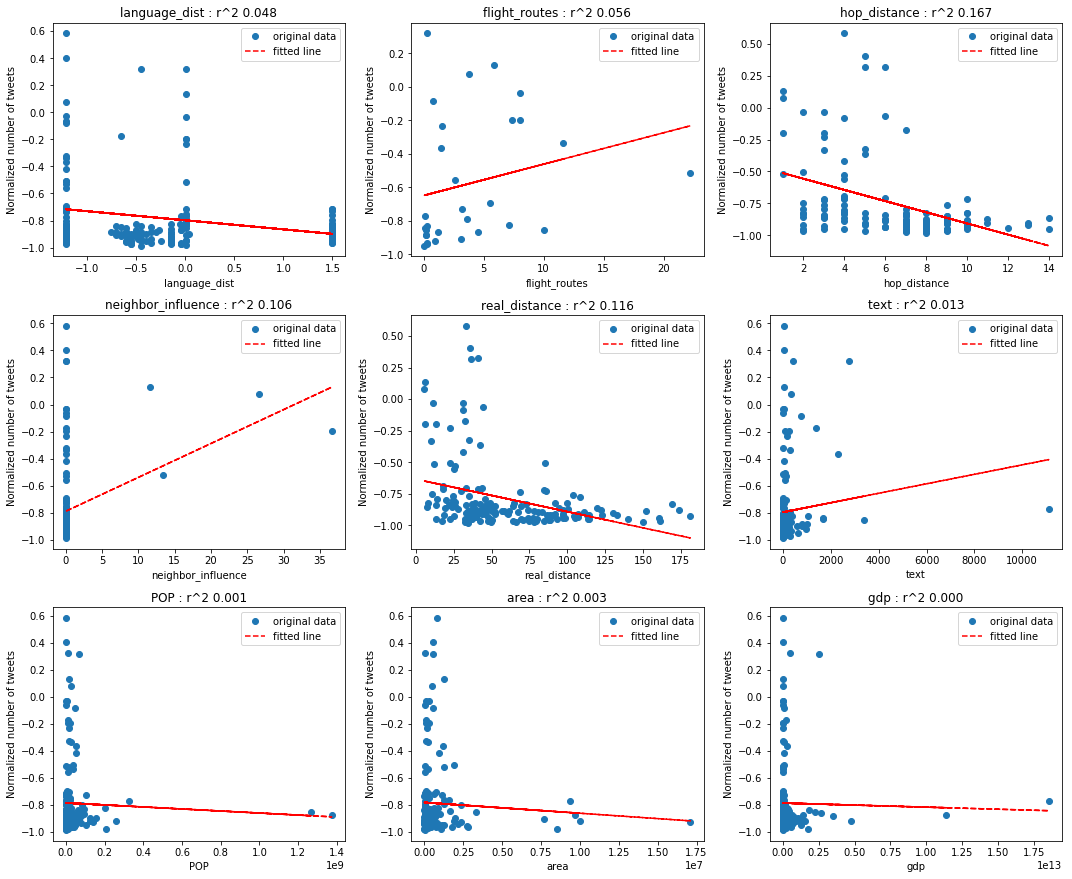

In [12]:
analyse_event("Nigeria_2015", "NG")

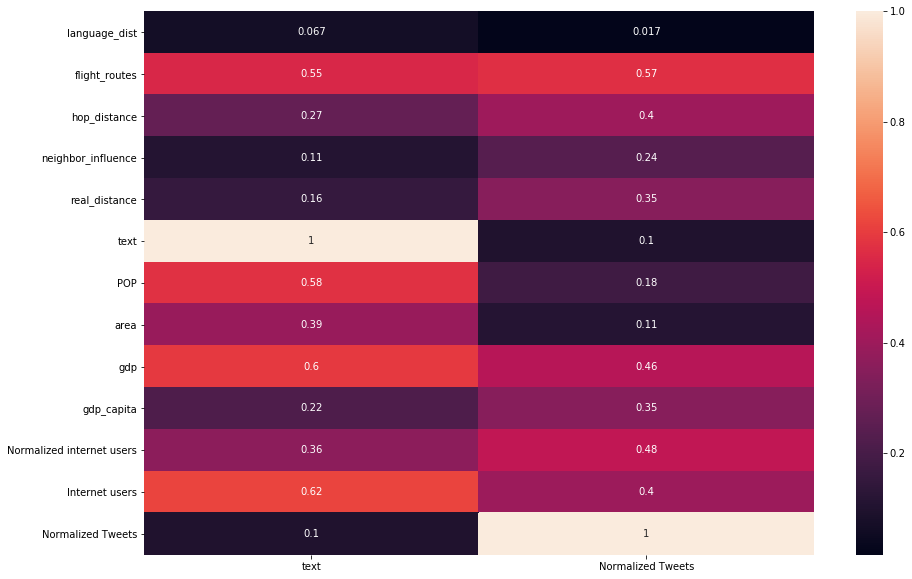

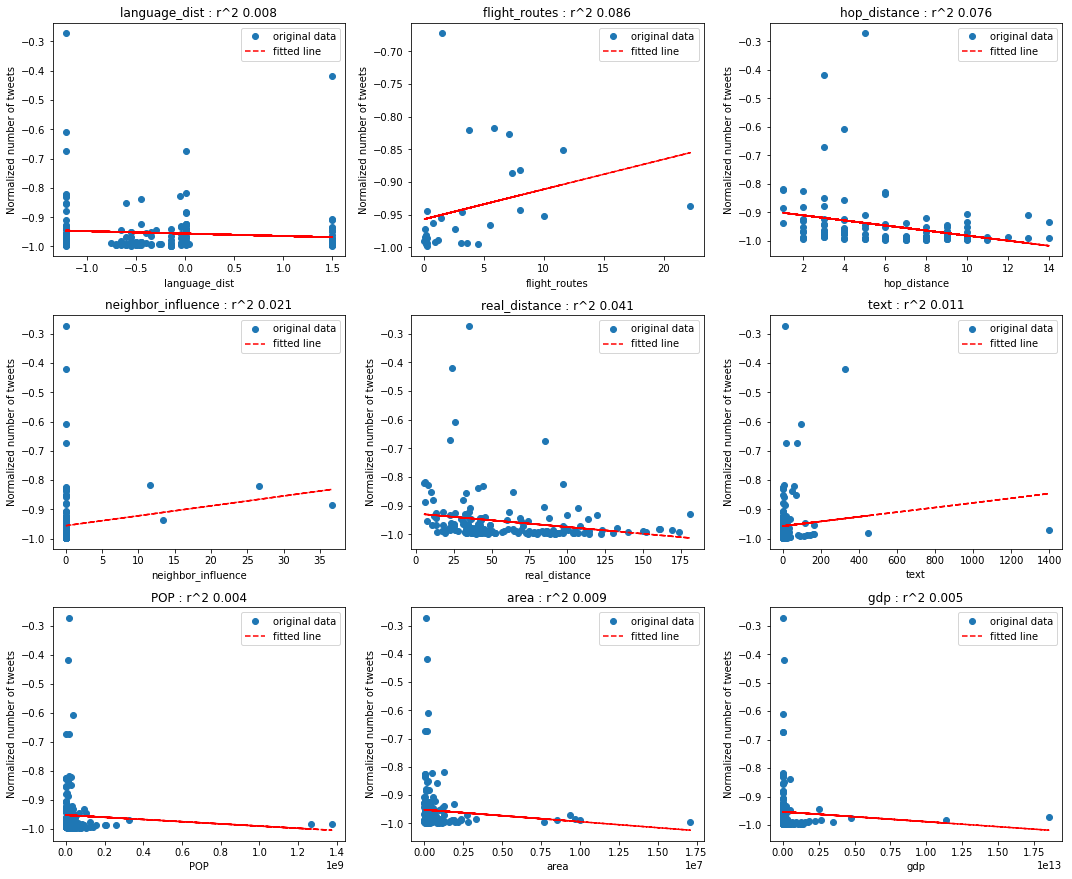

In [13]:
analyse_event("Nigeria_2016", "NG")

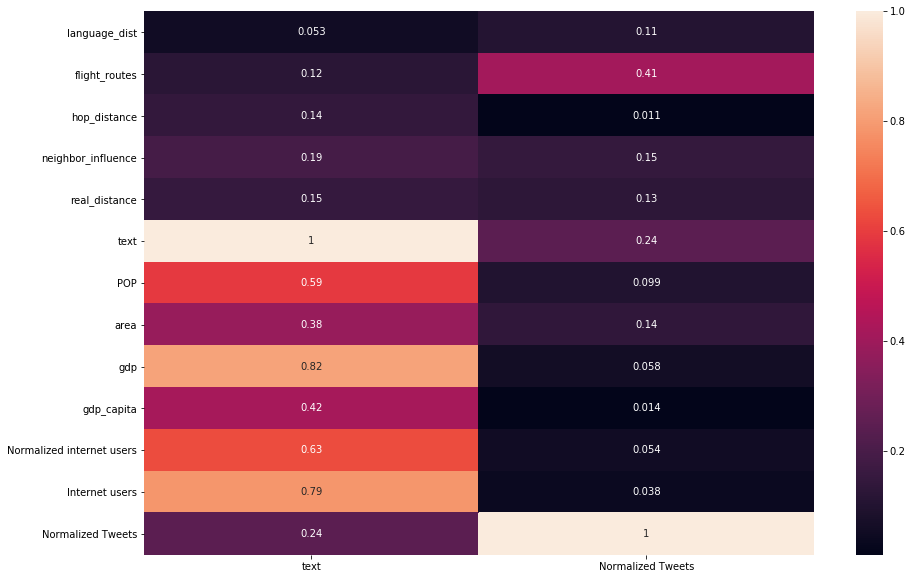

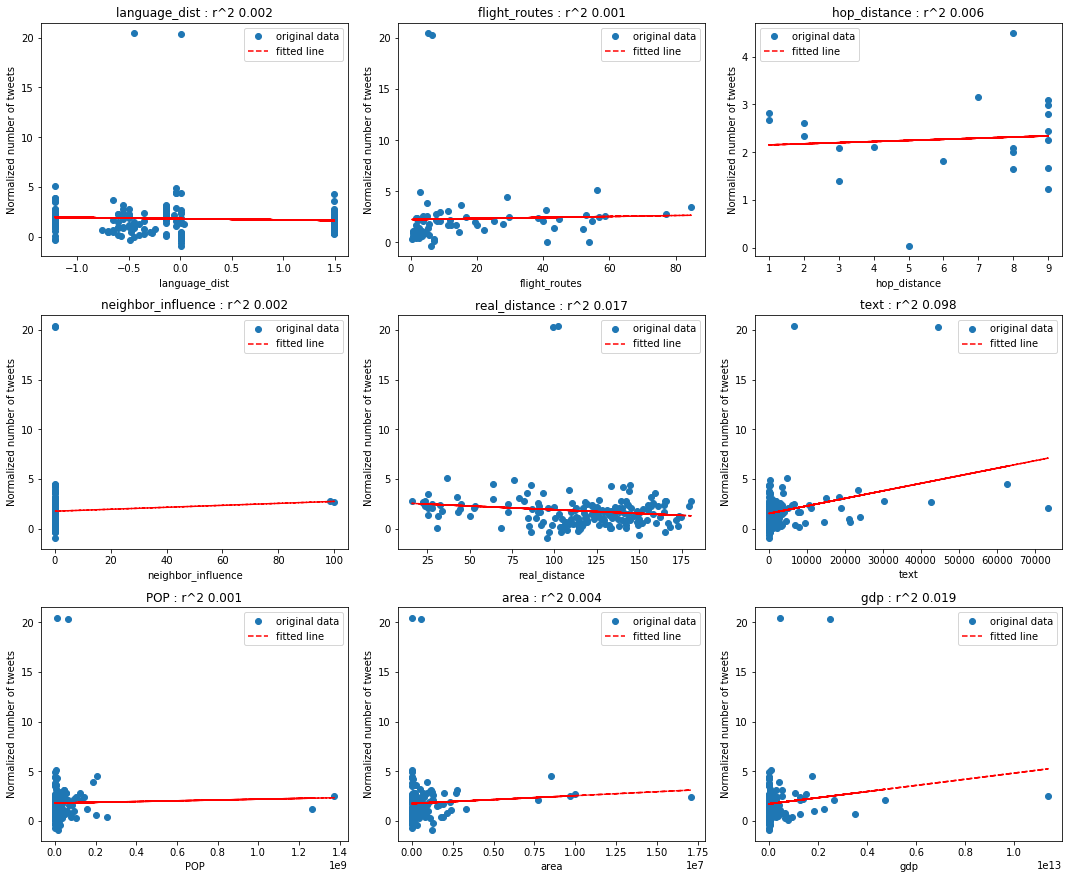

In [14]:
analyse_event("Orlando", "US")

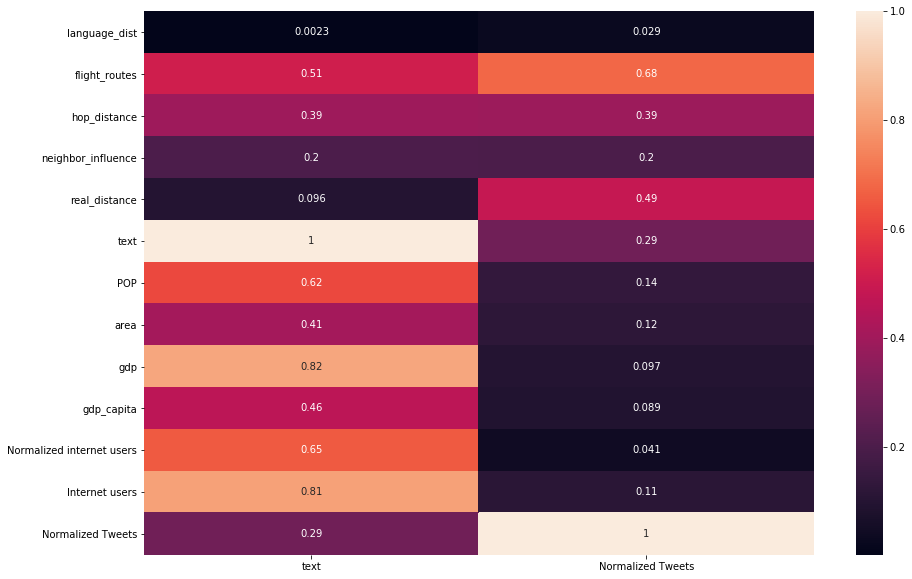

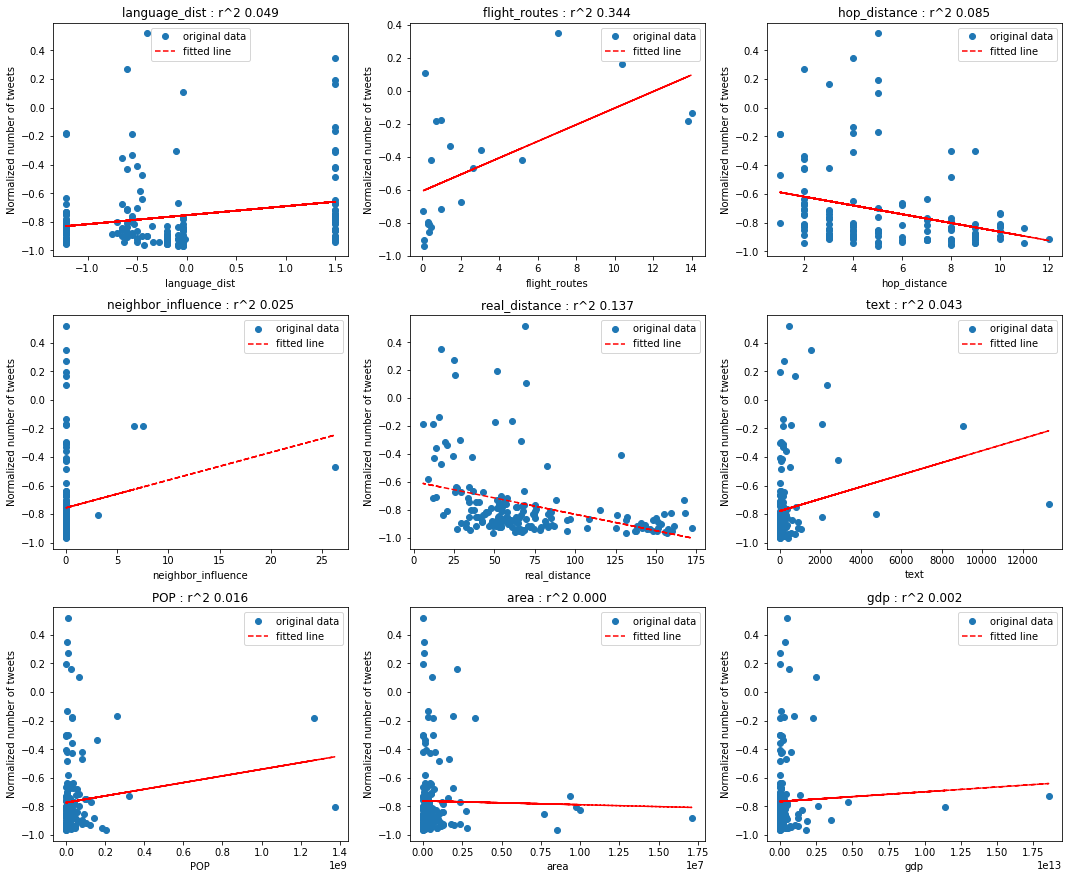

In [15]:
analyse_event("Pakistan", "PK")